In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time

In [86]:
input_file="DIS.csv"

# convert an array of values into a dataset matrix
# dataX: store sequences of look_back time steps
# dataY: store the corresponding value of the next time step ater each sequence
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [87]:
# fix random seed for reproducibility
np.random.seed(5)

# load the dataset
df = read_csv(input_file, header=None, index_col=None, delimiter=',')

In [88]:
# take close price column[5]
all_y = df[5].values

# normalize the dataset
dataset=all_y.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [89]:
# split into train and test sets, 50% test data, 50% training data
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
# train: the first train_size rows from the dataset
# test: the remaining rows from train_size to the end of the dataset
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1, timestep 240
# look_back: the number of previous time steps to use as input features to predict the next time step
look_back = 240
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=240, verbose=1)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [93]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.48 RMSE
Test Score: 16.20 RMSE


In [94]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [95]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

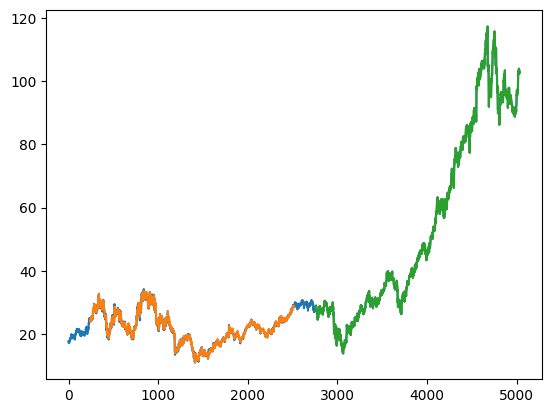

In [102]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])
plt.plot(range(len(trainPredict) + (look_back * 2) + 1, len(dataset) - 1), testPrices)
plt.show()

In [97]:
# export prediction and actual prices
df = pd.DataFrame(data={"prediction": np.around(list(testPredict.reshape(-1)), decimals=2), "test_price": np.around(list(testPrices.reshape(-1)), decimals=2)})
df.to_csv("lstm_result.csv", sep=';', index=None)